In [14]:
import torch
class GAN_Generator(torch.nn.Module):
    
    def __init__(self, convtrans_channel=[6,3,1], conv_channel=[1,3,6,1],z_dim=64,channel_input=1,bs=128,device='cuda'):
        
        super(type(self), self).__init__()
        self.z_dim=z_dim
        self.batch=bs
        self.channel=channel_input
        self.device=device
        
        self.generative_layers = torch.nn.Sequential(
                                  torch.nn.ConvTranspose2d(self.channel,convtrans_channel[0],4,stride=2,padding=2 ),
                                  torch.nn.BatchNorm2d(convtrans_channel[0]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[0],convtrans_channel[1],5,padding=4),
                                  torch.nn.BatchNorm2d(convtrans_channel[1]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[1],convtrans_channel[1],5,padding=2),
                                  torch.nn.BatchNorm2d(convtrans_channel[1]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[1],convtrans_channel[1],5,padding=2),
                                  torch.nn.BatchNorm2d(convtrans_channel[1]),
                                  torch.nn.ReLU(True),
                                  torch.nn.ConvTranspose2d(convtrans_channel[1],convtrans_channel[2],3,stride=2),
                                  #torch.nn.Sigmoid(),
                                  #torch.nn.Tanh(),
                                  
            
                                )
    

                
    
    def generador(self, z):
        z=z.view(-1,self.channel,8,8)
        x_falso=self.generative_layers(z)
        x_falso=self.normalize(x_falso)
        #print(x_falso)
        return x_falso
            
    def sample(self,size):
        z=torch.randn(size,self.channel*self.z_dim , device=self.device)
        return z
    
    def normalize(self,x):
        im_min = x.min(dim=-1).values.min(dim=-1).values.reshape(-1, 1, 1, 1)
        im_max = x.max(dim=-1).values.max(dim=-1).values.reshape(-1, 1, 1, 1)
        x = (x - im_min)/(im_max-im_min)
        return x
       

class GAN_Discriminator(torch.nn.Module):
    
    def __init__(self, convtrans_channel=[6,3,1], conv_channel=[1,3,6,1],z_dim=100,channel_input=1,bs=128,device='cuda'):
        
        super(type(self), self).__init__()
        self.z_dim=z_dim
        self.batch=bs
        self.channel=channel_input
        self.device=device
        
        ##capas generadoras
        self.discriminator_layers= torch.nn.Sequential(
                                   torch.nn.Conv2d(conv_channel[0],conv_channel[1],5,stride=2,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[1]),
                                   torch.nn.LeakyReLU(0.2),
                                   torch.nn.Conv2d(conv_channel[1],conv_channel[2],5,stride=3,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[2]),
                                   torch.nn.LeakyReLU(0.2),
                                   torch.nn.Conv2d(conv_channel[2],conv_channel[3],5,stride=2,padding=1),
                                   torch.nn.Sigmoid(),                                
        
                                )

        
    def discriminador(self,supuesto_x):
        noise=torch.randn(supuesto_x.shape , device=self.device) ##agregando ruido blanco gaussiano
        supuesto_x= torch.clamp(supuesto_x + noise,0.0, 1.0) 
        supuesto_x=self.discriminator_layers(supuesto_x)
        supuesto_x=supuesto_x.view(-1)
        return supuesto_x
    
def loss_disc(disc_datos_xfalso,disc_datos_x,size):
    loss=(torch.log(disc_datos_x) + torch.log(1 - disc_datos_xfalso) ).sum() / size
    return -loss
    
def loss_gen(disc_datos_xfalso,size):
    loss=torch.log(disc_datos_xfalso).sum() / size
    return -loss

In [74]:
ls /opt/data-nas/HiTS

images_test.csv*  images_train.csv*  label_test.csv*  label_train.csv*


### cargamos el CSV de entrenamiento

In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("/opt/data-nas/HiTS/images_train.csv",header=None)
differences=np.array(df.iloc[:,0:21*21])
df=0  ##manera trucha de liberar memoria by javier rojas
df=pd.read_csv("/opt/data-nas/HiTS/label_train.csv",header=None)
labels=np.array(df)
df=0

### creamos dataloader

In [2]:
from torch.utils.data import TensorDataset, DataLoader, Subset 
batch_size=128
astro_image_tensor=torch.from_numpy(differences.astype('float32')).view(-1,1,21,21)
im_min = astro_image_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 1, 1, 1)
im_max = astro_image_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 1, 1, 1)
astro_image_tensor = (astro_image_tensor - im_min)/(im_max-im_min)

astro_dataset = TensorDataset(astro_image_tensor, torch.from_numpy(labels))

train_loader = DataLoader(astro_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

NameError: name 'differences' is not defined

In [15]:
### test section
import torchvision
import torchvision.datasets as datasets
import numpy as np

batch_size=32
mnist_train_data = torchvision.datasets.MNIST('dataset', train=True, download=True,
                                              transform=torchvision.transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST('dataset', train=False, download=True,
                                             transform=torchvision.transforms.ToTensor())
from torch.utils.data import DataLoader, SubsetRandomSampler

np.random.seed(0)
#idx = list(range(len(mnist_train_data)))
idx = list(range(10000))
np.random.shuffle(idx)
split = int(0.7*len(idx))

train_loader = DataLoader(mnist_train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(mnist_train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(idx[split:]))


## Entrenamiento

In [16]:
from tqdm import tqdm_notebook
n_epoch=500
k_disc=1
device='cuda'
GEN=GAN_Generator(bs=batch_size).cuda()
DISC=GAN_Discriminator(bs=batch_size).cuda()
optimizer_gen = torch.optim.Adam(GEN.parameters(), lr=0.0002)
optimizer_disc = torch.optim.Adam(DISC.parameters(), lr=0.0002)
den = train_loader.__len__()*train_loader.batch_size
criterion = torch.nn.BCELoss()
global_loss=np.inf
for epoch in tqdm_notebook(range(n_epoch)):
    for k in range(k_disc):
        train_disc_loss=0.0
        train_gen_loss=0.0
        for image,label in train_loader:
            optimizer_disc.zero_grad()  
            ##Para Mnist
            image=image[:,:,7:28,7:28]
            im_min = image.min(dim=-1).values.min(dim=-1).values.reshape(-1, 1, 1, 1)
            im_max = image.max(dim=-1).values.max(dim=-1).values.reshape(-1, 1, 1, 1)
            image = (image - im_min)/(im_max-im_min)
            ##fin de Mnist
            image=image.cuda()
            
            ##Train for real images
            output_real = DISC.discriminador(image)#.view(-1)
            label = torch.full((image.shape[0],), 1.0, dtype=torch.float, device=image.device)
            lossD_real=criterion(output_real,label)
            lossD_real.backward()
            ##Train disc fake image
            label.fill_(0)
            fake=GEN.generador(GEN.sample(image.shape[0]))
            output_fake_D = DISC.discriminador(fake.detach())#.view(-1)
            lossD_fake=criterion(output_fake_D,label)
            lossD_fake.backward()
            #lossD=loss_disc(output_fake_D,output_real,image.shape[0])
            #lossD.backward()
            total_loss=lossD_fake + lossD_real
            optimizer_disc.step()
            #train_disc_loss += lossD.item()
            train_disc_loss+=total_loss.item() /den
            
            ##Train generator
            optimizer_gen.zero_grad()  
            label.fill_(1) 
            output=DISC.discriminador(fake)#.view(-1)
            lossG=criterion(output,label)
            #lossG=loss_gen(output,image.shape[0])
            lossG.backward()
            #optimizer_disc.step()
            optimizer_gen.step()
            train_gen_loss+=lossG.item() / den
                               
                                 
            
            
    print("Train loss discriminador: %f  Train loss Generator :%f "%(train_disc_loss,train_gen_loss))



/home/admin/miniconda3/envs/PT/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


Train loss discriminador: 0.040952  Train loss Generator :0.023764 
Train loss discriminador: 0.041626  Train loss Generator :0.023427 
Train loss discriminador: 0.043588  Train loss Generator :0.023123 
Train loss discriminador: 0.043956  Train loss Generator :0.022845 
Train loss discriminador: 0.043085  Train loss Generator :0.023089 
Train loss discriminador: 0.042589  Train loss Generator :0.022838 
Train loss discriminador: 0.042738  Train loss Generator :0.022167 
Train loss discriminador: 0.042190  Train loss Generator :0.022842 
Train loss discriminador: 0.043033  Train loss Generator :0.022786 
Train loss discriminador: 0.042582  Train loss Generator :0.022620 
Train loss discriminador: 0.042376  Train loss Generator :0.022525 
Train loss discriminador: 0.042890  Train loss Generator :0.022582 
Train loss discriminador: 0.042430  Train loss Generator :0.022966 
Train loss discriminador: 0.042304  Train loss Generator :0.022631 
Train loss discriminador: 0.042314  Train loss G

KeyboardInterrupt: 

In [ ]:
model=GAN(device='cpu')


In [ ]:
filter(lambda p: p.requires_grad, model.parameters())

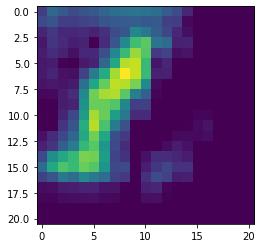

In [72]:
import matplotlib.pyplot as plt
plt.imshow(GEN.generador(GEN.sample(1))[0][0].cpu().detach().numpy())

In [39]:
while(True):
    kkita=GEN.generador(GEN.sample(1))
    kk=DISC.discriminador(kkita).cpu().detach().numpy()[0]
    if(kk>0.8):
        print(kk)
        print("lo logre")
        break;

0.8446424
lo logre


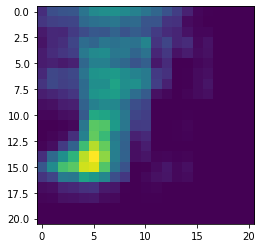

In [40]:
plt.imshow(kkita[0][0].cpu().detach().numpy())

In [56]:
model.parameters

NameError: name 'model' is not defined

In [ ]:
for parameter in model.parameters():
    print(parameter)

In [ ]:
kkita.shape